## Perturbation of sequences
### Dataset: Coronaviridae S Protein sequences of Humans only
### Number of sequences = 2400
### Model: Transformer

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/..']

In [2]:
from prediction.models.nlp import transformer, transformer_model, cnn1d, lstm, fnn
from prediction.datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from src.utils.nlp_utils.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts_human.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230917/perturbed_dataset_prediction/transformer-l_6-h_8-lr1e-4/processed"
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230908"


uniprotkb_coronaviruses_human_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

test_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 1,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

In [4]:
uniprotkb_coronaviruses_human_df

,id,seq,virus,seq_len,virus_host,binary_label
0,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
1,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens (Human) [TaxID: 9606],Human
2,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens (Human) [TaxID: 9606],Human
3,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human
4,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human
...,...,...,...,...,...,...
2395,T1PZ80,MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPT...,Human coronavirus NL63 (HCoV-NL63),643,Homo sapiens (Human) [TaxID: 9606],Human
2396,T1PZ81,MFLILLISLPTAFAVIGDLNCPLDTRLKGSFNNRDTGPPSISTDTV...,Human coronavirus OC43 (HCoV-OC43),929,Homo sapiens (Human) [TaxID: 9606],Human
2397,T1PZ82,QADSFTCNNIDAAKIYGMCFSSITIDKFAIPNRRKVDLQLGNLGYL...,Human coronavirus OC43 (HCoV-OC43),297,Homo sapiens (Human) [TaxID: 9606],Human
2398,T1PZ83,MFLILLISLPTAFAVIGDLNCPLDPRLKGSFNNRDTGPPSISTDTV...,Human coronavirus OC43 (HCoV-OC43),933,Homo sapiens (Human) [TaxID: 9606],Human


<AxesSubplot:xlabel='seq_len', ylabel='Count'>

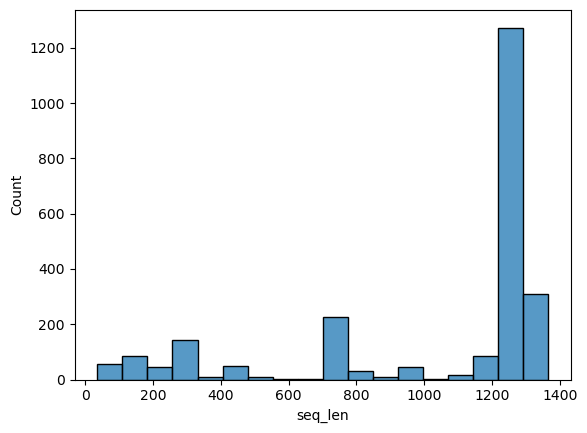

In [5]:
sns.histplot(uniprotkb_coronaviruses_human_df["seq_len"])

In [17]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(uniprot_id):
    id_df = uniprotkb_coronaviruses_human_df[uniprotkb_coronaviruses_human_df["id"] == uniprot_id]
    print(f"Size {uniprot_id} df = {uniprotkb_coronaviruses_human_df.shape}")
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

### Load the model

In [18]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-4-e50", "transformer-custom-l_6-h_8-lr1e-4_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

In [19]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [71]:
output_files = os.listdir(output_dir)
len(output_files)

970

In [52]:
mean_diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"tf\_coronaviridae\_top\_7\_hosts_human\.csv\_([A-Z0-9]+)\.csv", output_file)
    uniprot_id = regex_result.group(1)
    uniprot_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(uniprot_id)
    
    # do analysis for only sequences with length >= 1200
    uniprot_id_seq = uniprot_id_df["seq"].values[0]
    if len(uniprot_id_seq) < 1200:
        continue
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")
    mean_diff_dfs.append(pivot_df.mean(axis=0))
    

Size A0A0A0QCK9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M7M0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JF30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JQG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y9M5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HFX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JCL6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0W8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCR6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6KR24 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RGR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0PKZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A883GQ18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G5B0B7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JHP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YG78 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVK3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R984 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RCC7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A891F0L4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EVP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLB4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RBS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VCL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLN3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGJ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A385H603 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RHL7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JJP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RJY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K5I6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JN20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EBU0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZEY4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RKH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E932 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KWA2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMB3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATX1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HHP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RSK3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAN9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A883GQC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JSC3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATB9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7W9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JFM7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384QZE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BH40 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EQA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RG54 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JV53 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZNY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDF2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEX4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A891F0I3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3W0Q2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U1HBQ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VEX5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6B9V081 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JQL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3RIT3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE13 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KLY6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRG4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVK8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFA9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K1D6F6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE08 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R9E4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RCU4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0L9E5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897FE50 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A897EF70 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ECZ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Z6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N6Y5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDH8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T257 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATX6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCF7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K290 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5B9BHU7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0G2RCD5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6KUU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JMI4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFW5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A451ERM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1LC10 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G7K2M4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127ATT4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW09 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M7L8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDA5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H9EJ16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6REG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A891F0M1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VEK4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMR0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDF7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDG2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Y9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QCI9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YCH0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KE13 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HDU0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M3SPN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RH07 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ELM2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K140 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VQ38 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R924 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RW32 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J2D2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A8E2W5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B0G593 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JBZ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y870 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T1L4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KDR9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGW7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A4L516 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R972 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JH05 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PYX9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size M1PF06 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TMS5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RVE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBY3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A3H1W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1G1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M4NDS5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCB1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVL0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y8C3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7H2DTM2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4ZKZ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size C1J1E8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JBA1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JF17 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE68 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7H4JBY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HHA5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q5MQD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0G2Y6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDM5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0Q9Q4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0U1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size E0YJ44 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JI69 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5TMT7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E931 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RAD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JZ39 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EL45 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0PL04 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U0FD30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K6H7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HH46 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899KA80 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMD0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFB8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AT52 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAD8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KE28 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N7I9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A859GSW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KW27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EDT1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T6K8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0A0QAE5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2SDZ7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YF87 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K305 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKY6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1XVY9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AWP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D8AIA7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T8HBN7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJG7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8S2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JNF0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9F2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1IVJ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A3S6FH27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AX91 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EVE2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE59 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9Q2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L9W1C3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE11 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K0H1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6H2TXT6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A891F0C9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAQ9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JDH2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A4M215 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K6C7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AX84 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KVP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JQS2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMW4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JTY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JR91 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Z4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JRM6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMC4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3HGG2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JW33 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JRZ4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L4YH07 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VE64 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JKH3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JES6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1L5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K3L9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9H2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0HWR1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7N8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RPH9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6REM7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AU03 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5J9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6H0YZY1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HJV4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8R1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K350 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size S5YNN4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JAI5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIE4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KDQ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6L9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A897FM41 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U0TJY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A513ZT30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q06XN1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDG8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K4J0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLJ5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R9X0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6B9UZU2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I4DEW9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HG43 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDX7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6J3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A859GU28 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A883GPJ3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JM56 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A3G2KXL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2P1E904 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ELF2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0L9K1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0D6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384QXL8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATK7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J9P3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T265 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K057 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7M1Y488 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7T0YN88 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5J4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JKS8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QAE7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1L0D6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KFT9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1KWC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBI3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384RNP7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897FF12 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JMQ2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4T375 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JKE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HH24 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K352 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1W6E033 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YBW2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RCA3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6G9ZXC8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JW99 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K4F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B0GA47 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RK54 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A127AVA4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBJ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G9XXL3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K347 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDI8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFE9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JIP4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CWK2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A224AU27 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A482KBY9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5TKW5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIA6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YF37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RX26 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5B9BH24 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHD2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M6LUN0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y920 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N608 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U42 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0G2RD16 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4SU81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size H9EJV2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H5X7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7T5QW37 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RBD2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7L5PKS3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J2N1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1V0E0Z4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HZF4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JTJ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFV7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JFV0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RFY2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CY48 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HEP0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RMP2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YGH7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6REJ1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JJ71 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RCL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCP3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384RJY8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1ZWW3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7U3EC09 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIJ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YGC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QCI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899KBL9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJK3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YEY5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0BZ81 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7S6KUA8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4NEC6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q6Q1S2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE09 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RRX0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGW2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDF3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G302 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q1HVL7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4N344 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDI1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KE84 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JDD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5S0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384RHP9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T1L5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RF20 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HD14 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G3W0Q6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVL1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JZI4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJA1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YF97 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M6M541 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6R912 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRK6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J9G1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EE76 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A2Z5T1W4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7Z3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1K399 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6K8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1S5VGE0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2D1CLQ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0H3VDE3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT72 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size D3GDH1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N711 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4ZEZ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLI6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JTD6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJ55 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size U3M7P6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7F5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A6M4BCC7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0K0L8I8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A883GQB7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6A9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7Y966 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M7P4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLB2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A8E2W0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5B9BGI8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D3YBD3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JM59 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCC7 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0P0HDK1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R936 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JLH2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BGV5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1J0W4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KWM6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RJ46 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6H9X8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7VWR5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06Y10 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A859GW29 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZB8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q19U48 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZF01 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0K0KPR8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFZ6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Q4VIE8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KKS9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YA76 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N7J5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JHF1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JB18 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JFS5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1LCP1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VE75 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A3S6FHI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AWN2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A0B4N708 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K4T2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A384R9G2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMU6 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size I7CMD1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZI2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8A3ZKI0 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFK5 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A5K7YAM8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size S5YGG8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JJH3 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris g

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JR30 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A899K5F1 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H6K9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7D4ZP32 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGU9 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B1JVJ8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW15 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A7G1CW26 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RFS2 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A8B6RWW8 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6A4 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size A0A1Y0EV12 df = (2400, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagr

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

In [53]:
output_df

,Bovine,Chicken,Human,Japanese pipistrelle,Lesser bamboo bat,Pig,Wild turkey,y_true
0,0.012806,0.000008,0.975468,0.000124,0.000269,0.003223,0.008103,Human


In [54]:
perturbed_output_df

,Human,id,orig_token,perturb_pos,new_token,pred_diff
0,0.975458,A0A1Y0EV12,H,150,D,-0.000010
1,0.975445,A0A1Y0EV12,I,215,Q,-0.000022
2,0.975489,A0A1Y0EV12,L,134,B,0.000022
3,0.975486,A0A1Y0EV12,L,11,A,0.000018
4,0.975488,A0A1Y0EV12,R,817,M,0.000020
...,...,...,...,...,...,...
33871,0.975437,A0A1Y0EV12,A,1089,W,-0.000030
33872,0.976550,A0A1Y0EV12,S,839,X,0.001082
33873,0.975530,A0A1Y0EV12,L,1246,T,0.000062
33874,0.975499,A0A1Y0EV12,G,1149,K,0.000032


In [55]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

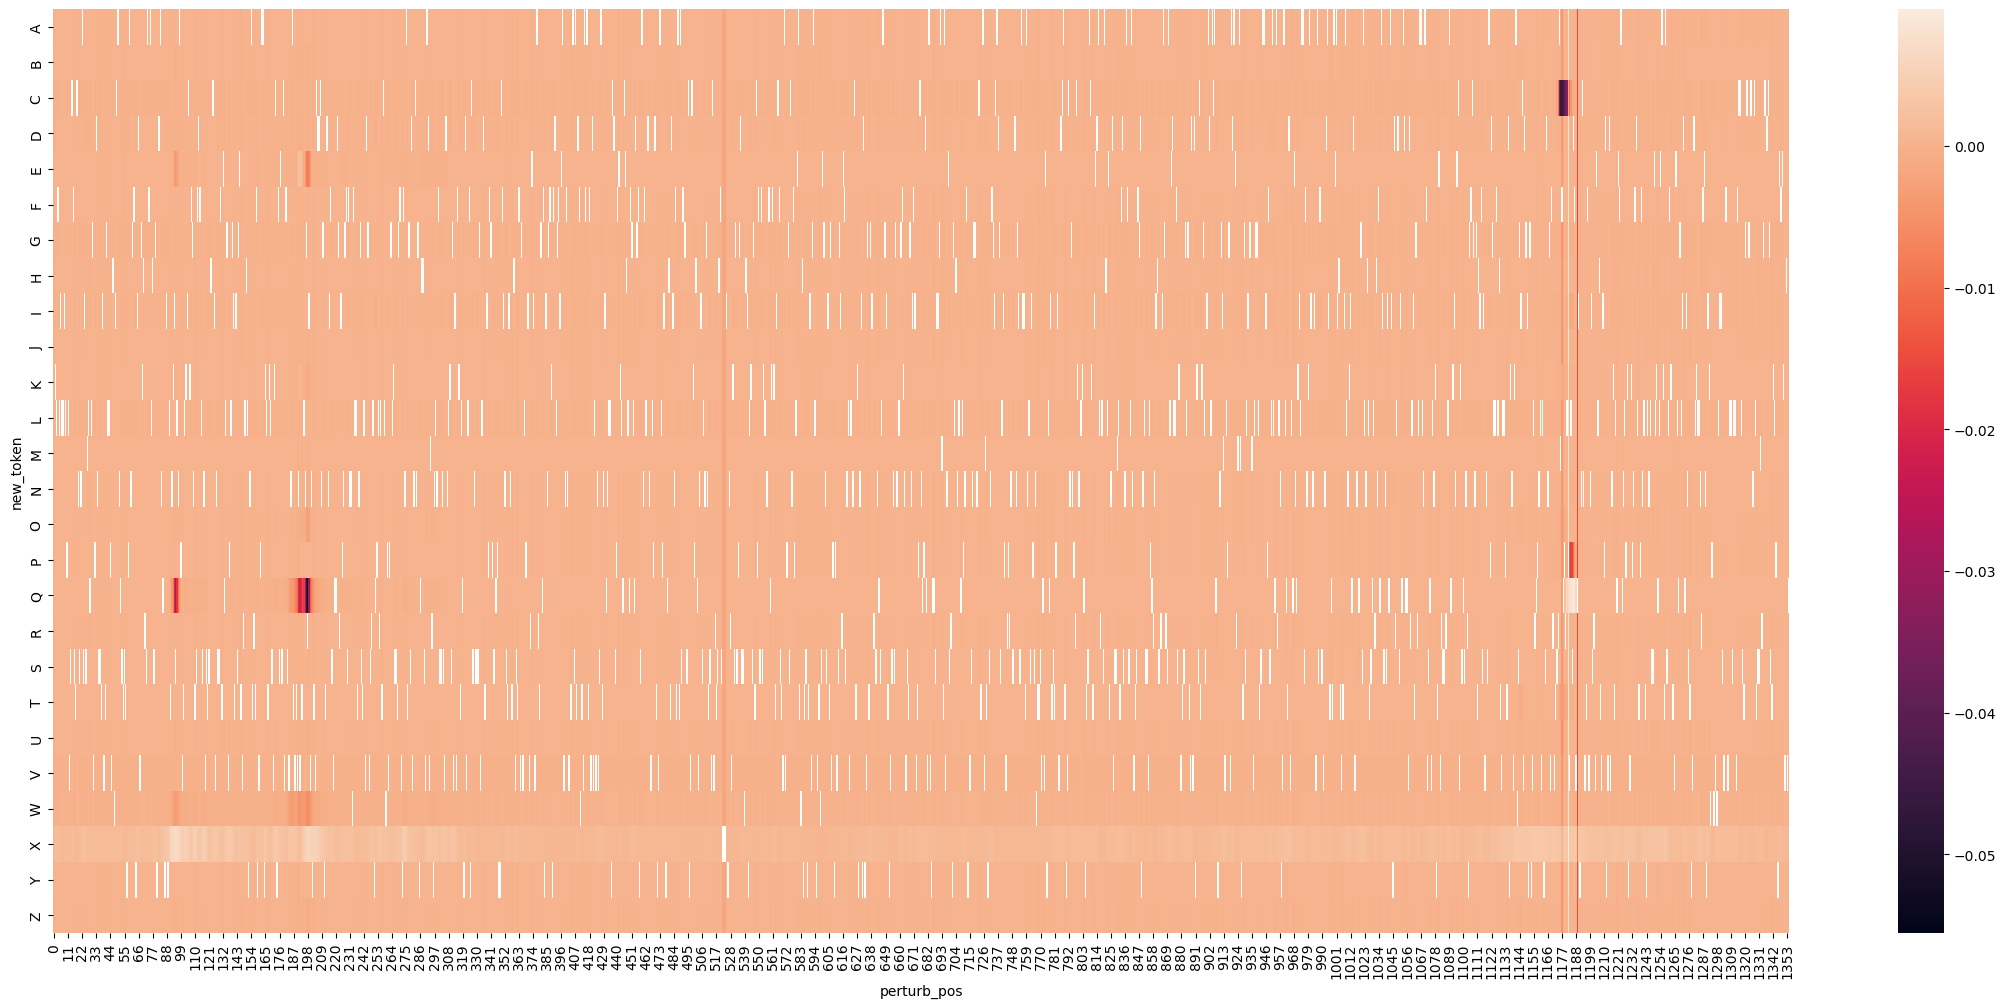

In [56]:
plt.figure(figsize=(28,12))
sns.heatmap(df)
plt.show()

In [57]:
df.mean(axis=0)

perturb_pos
0       0.000024
1       0.000043
2       0.000082
3       0.000053
4       0.000077
          ...   
1350    0.000023
1351    0.000156
1352    0.000038
1353    0.000177
1354    0.000019
Length: 1355, dtype: float64

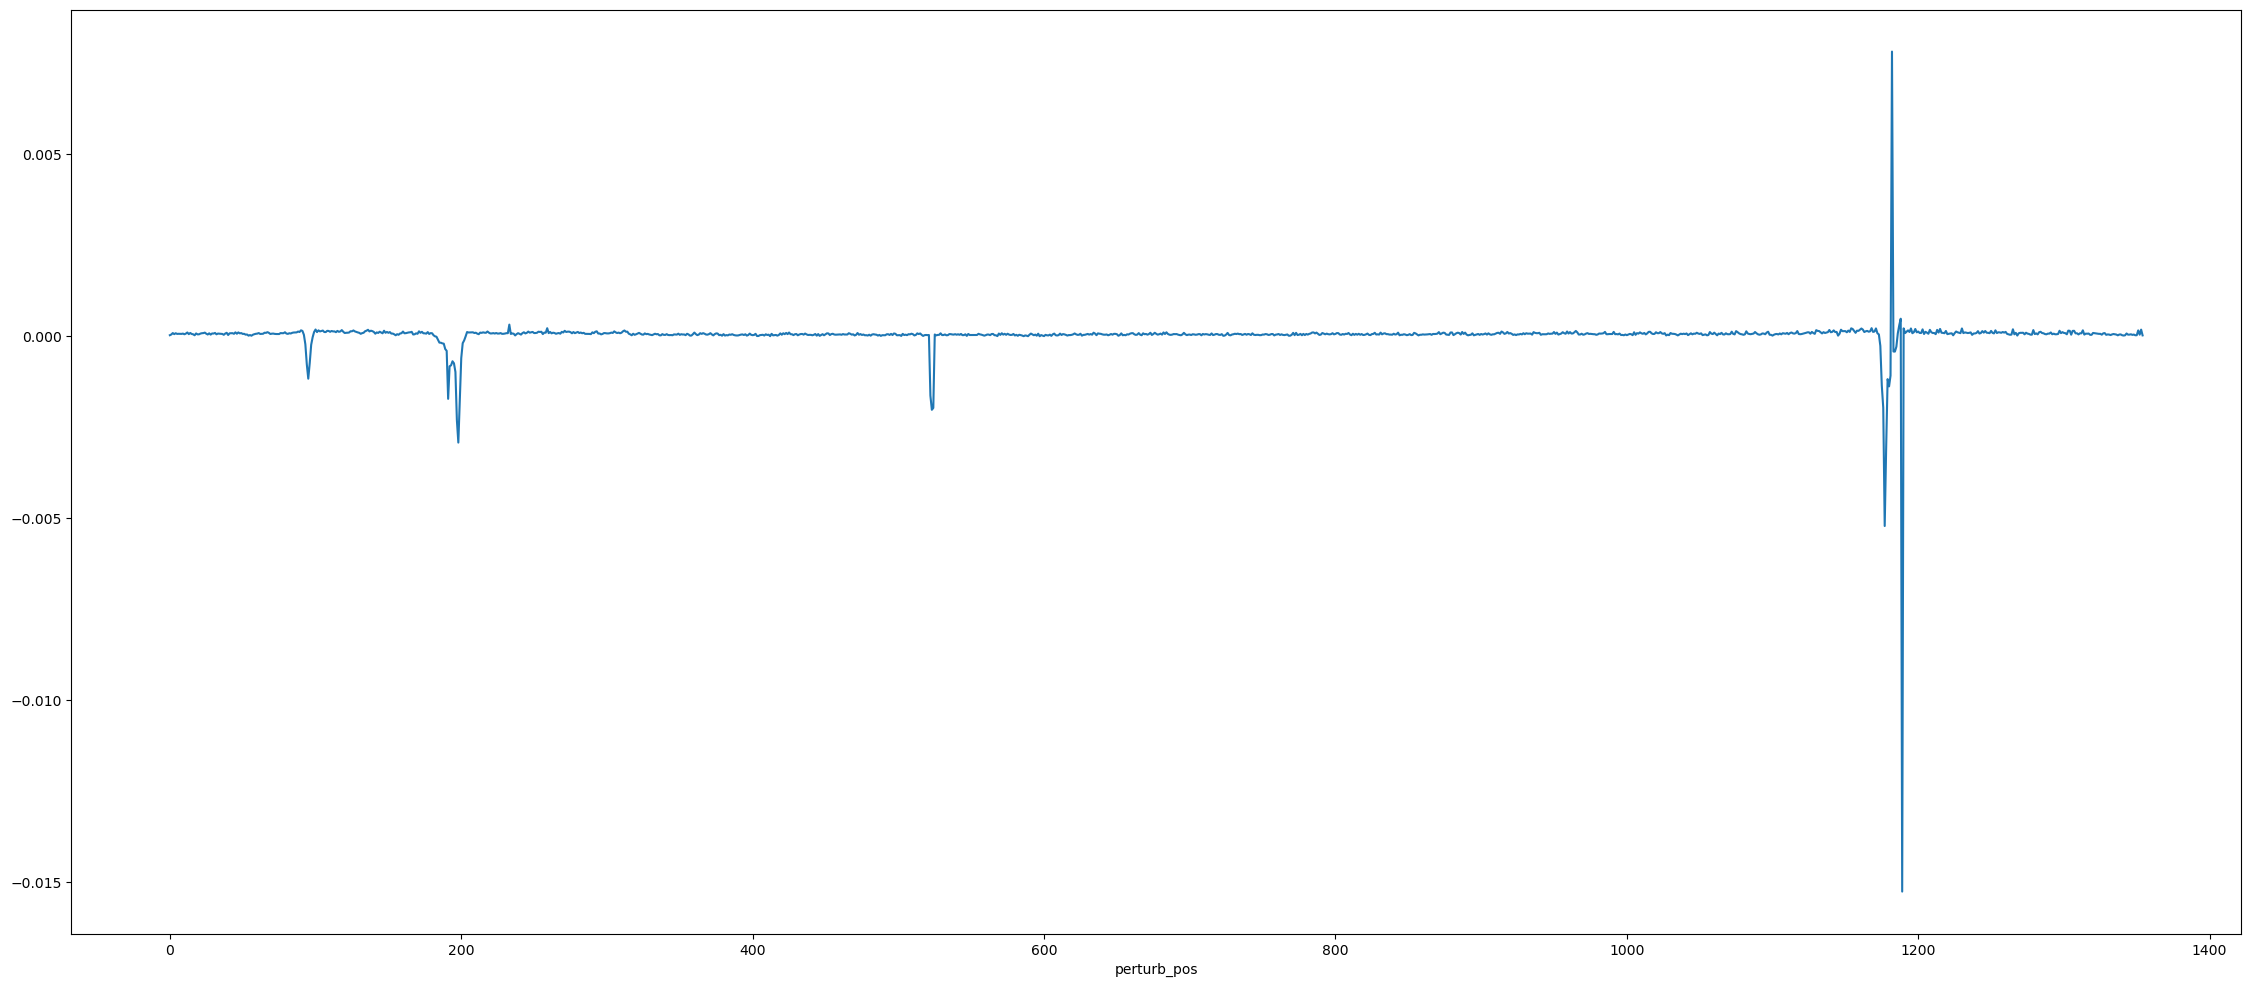

In [58]:
plt.figure(figsize=(28,12))
sns.lineplot(df.mean(axis=0))
plt.show()

In [59]:
df.mean(axis=0).idxmin()

1189

In [60]:
mean_diff_dfs

[perturb_pos
 0       1.165106e-05
 1       8.980242e-06
 2      -1.214096e-05
 3       6.271842e-06
 4       1.482417e-07
             ...     
 1268    4.557944e-05
 1269    2.102944e-05
 1270   -1.359936e-05
 1271    2.678504e-05
 1272   -1.000736e-05
 Length: 1273, dtype: float64,
 perturb_pos
 0       0.000236
 1       0.000279
 2       0.000148
 3       0.000291
 4       0.000195
           ...   
 1268    0.000377
 1269    0.000331
 1270    0.000387
 1271    0.000633
 1272    0.000690
 Length: 1273, dtype: float64,
 perturb_pos
 0       0.002822
 1       0.003083
 2       0.003811
 3       0.003206
 4       0.003532
           ...   
 1356    0.002635
 1357    0.002762
 1358    0.002405
 1359    0.002684
 1360    0.002582
 Length: 1361, dtype: float64,
 perturb_pos
 0       0.000097
 1       0.000120
 2       0.000025
 3       0.000115
 4       0.000069
           ...   
 1268    0.000203
 1269    0.000182
 1270    0.000154
 1271    0.000302
 1272    0.000319
 Length: 1273, dtyp

In [61]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)

In [62]:
mean_diff_df

perturb_pos,0,1,2,3,4,5,6,7,8,9,...,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363
0,0.000012,0.000009,-0.000012,0.000006,1.482417e-07,-0.000013,2.190417e-07,-5.841583e-07,-0.000027,7.558417e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000236,0.000279,0.000148,0.000291,1.949761e-04,0.000091,1.520521e-04,1.414777e-04,0.000125,1.651849e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002822,0.003083,0.003811,0.003206,3.531672e-03,0.003301,2.842416e-03,2.993612e-03,0.003177,2.697619e-03,...,0.002405,0.002046,0.002635,0.002762,0.002405,0.002684,0.002582,NaN,NaN,NaN
3,0.000097,0.000120,0.000025,0.000115,6.899804e-05,-0.000004,5.427844e-05,5.083724e-05,0.000011,6.462444e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000010,0.000008,-0.000009,0.000006,1.188678e-06,-0.000009,1.025878e-06,-5.852200e-08,-0.000025,3.502780e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,-0.000001,0.000009,0.000021,-0.000047,-9.657373e-06,-0.000002,3.286023e-05,3.879427e-06,-0.000015,-1.460337e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651,0.000010,0.000007,-0.000007,0.000006,1.337002e-06,-0.000007,1.211002e-06,1.542021e-07,-0.000024,4.370021e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,0.000012,0.000010,-0.000013,0.000008,3.696181e-06,-0.000014,3.280981e-06,2.001781e-06,-0.000027,2.714981e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,0.000962,0.000992,0.001153,0.001151,1.062411e-03,0.000989,1.007951e-03,1.040973e-03,0.000962,8.856185e-04,...,0.001065,0.000849,0.001067,0.001072,NaN,NaN,NaN,NaN,NaN,NaN


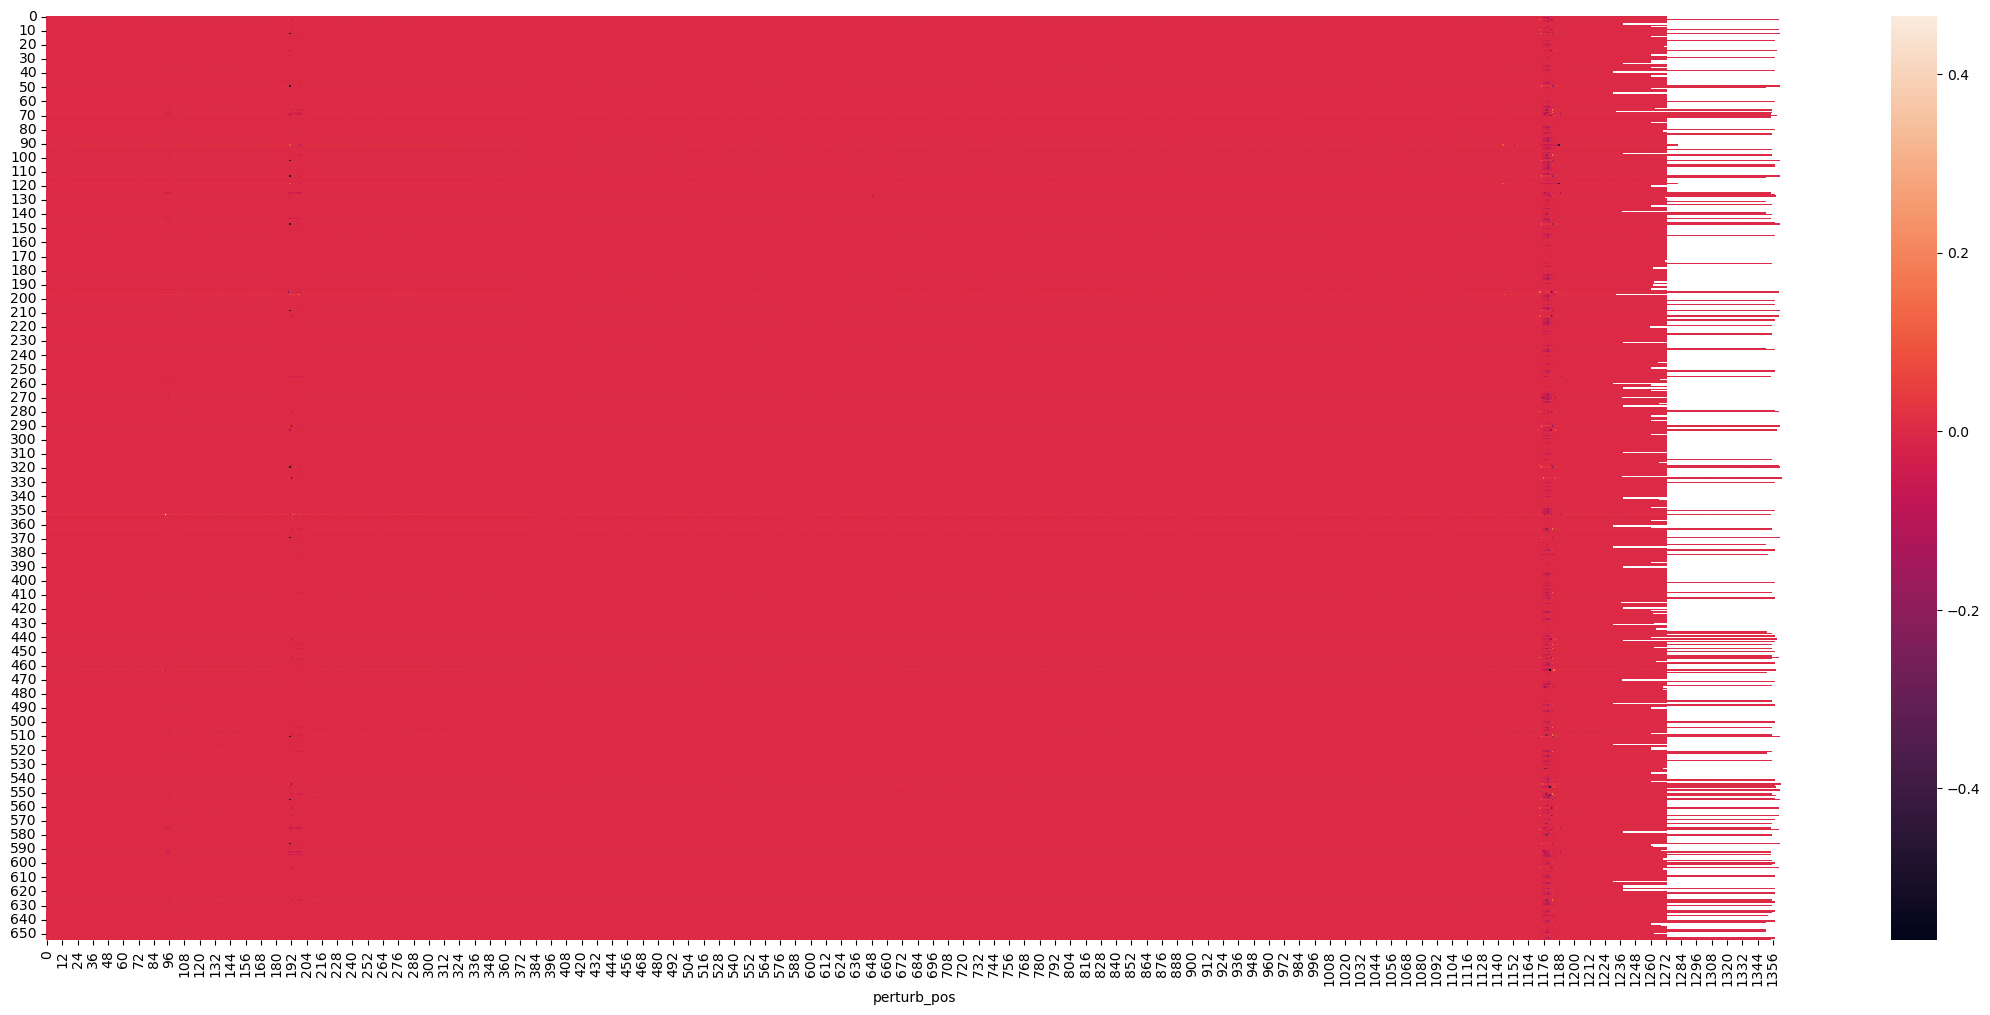

In [63]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

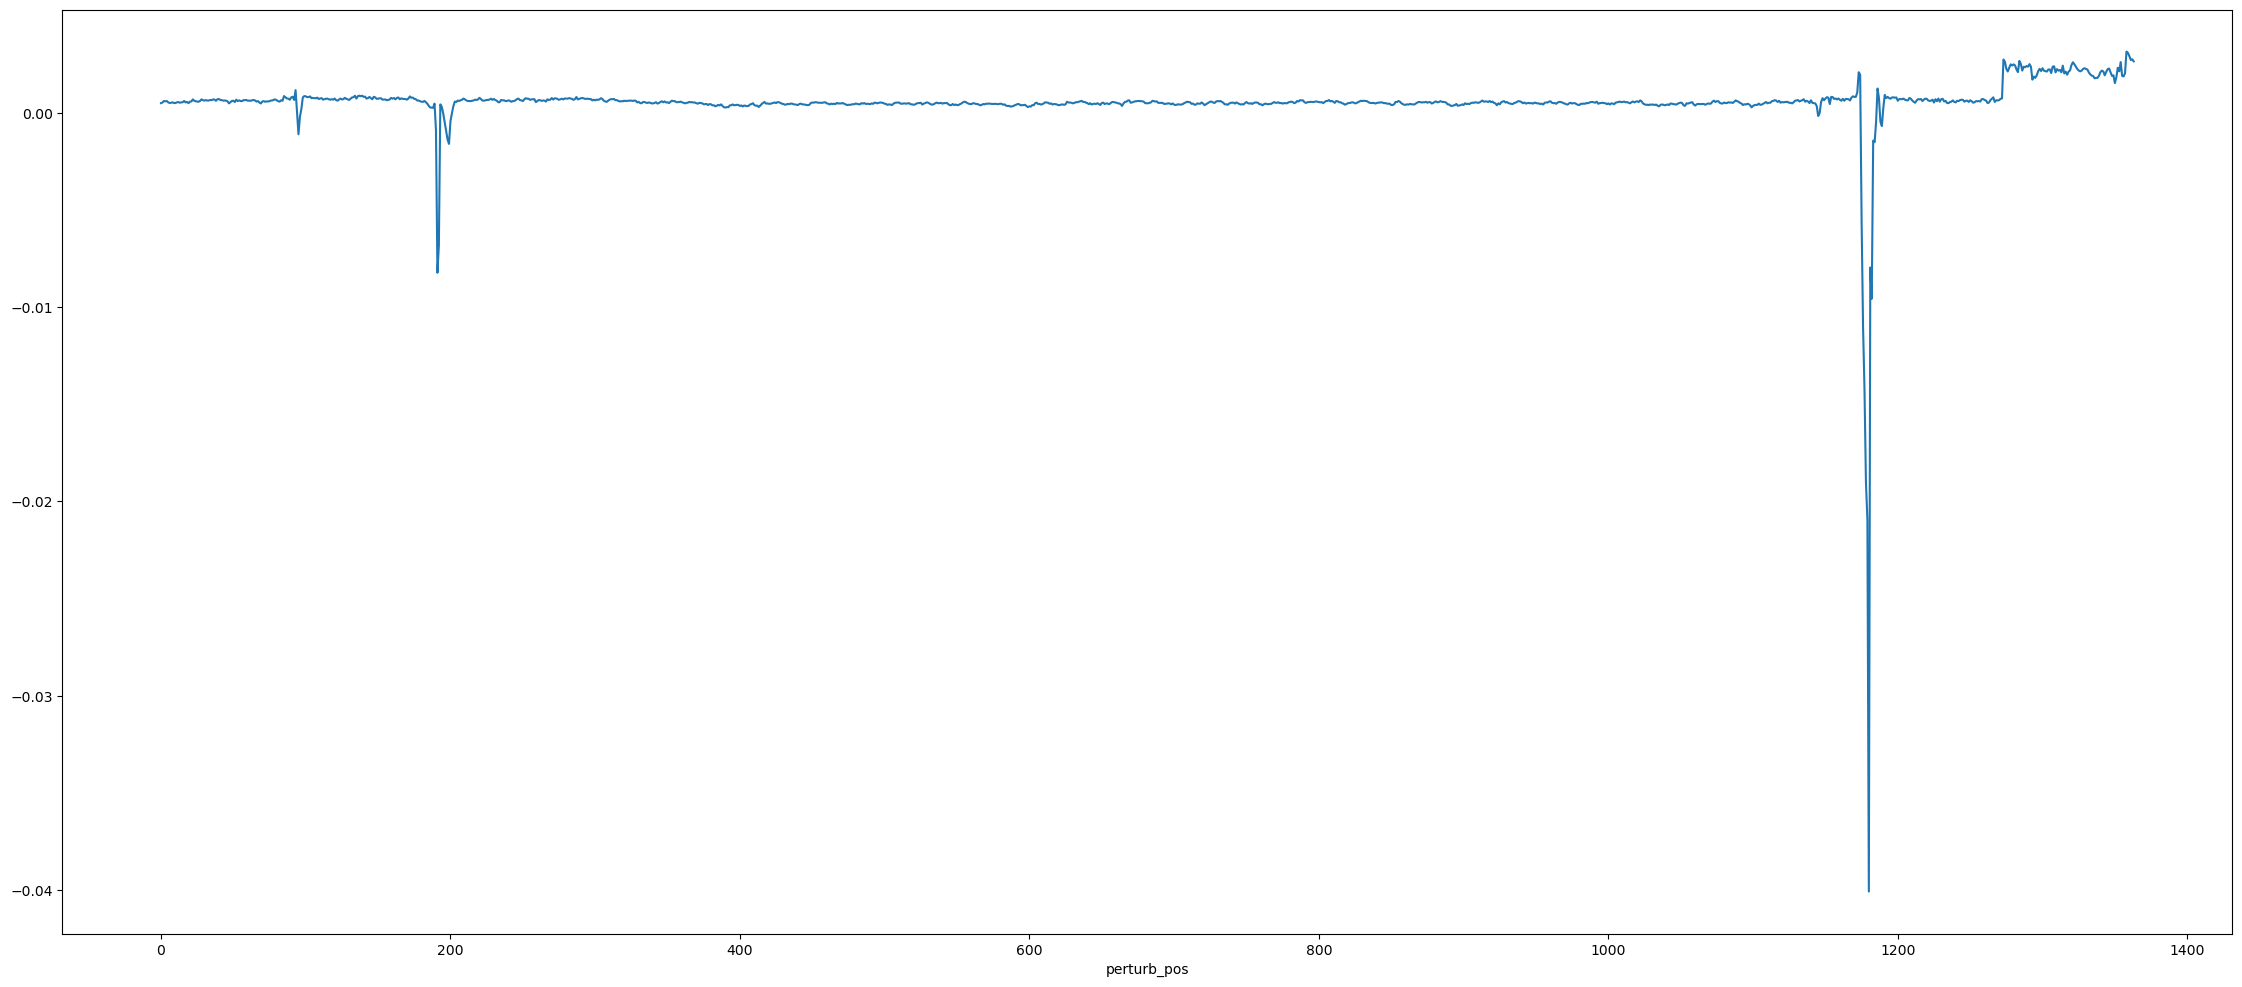

In [64]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [65]:
mean_diff_df.mean(axis=0).idxmin()

1180

In [66]:
# retain only negative values i.e. probability of Human host decreases
mean_diff_df[mean_diff_df >= 0 ] = None
# drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
# true_pred_attn_rank_df.dropna(axis=1, how="all", inplace=True)

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position is not in the top 10 for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
mean_diff_df.dropna(axis=1, how="all", thresh=0.9*mean_diff_df.shape[0], inplace=True)

In [67]:
mean_diff_df.shape

(655, 7)

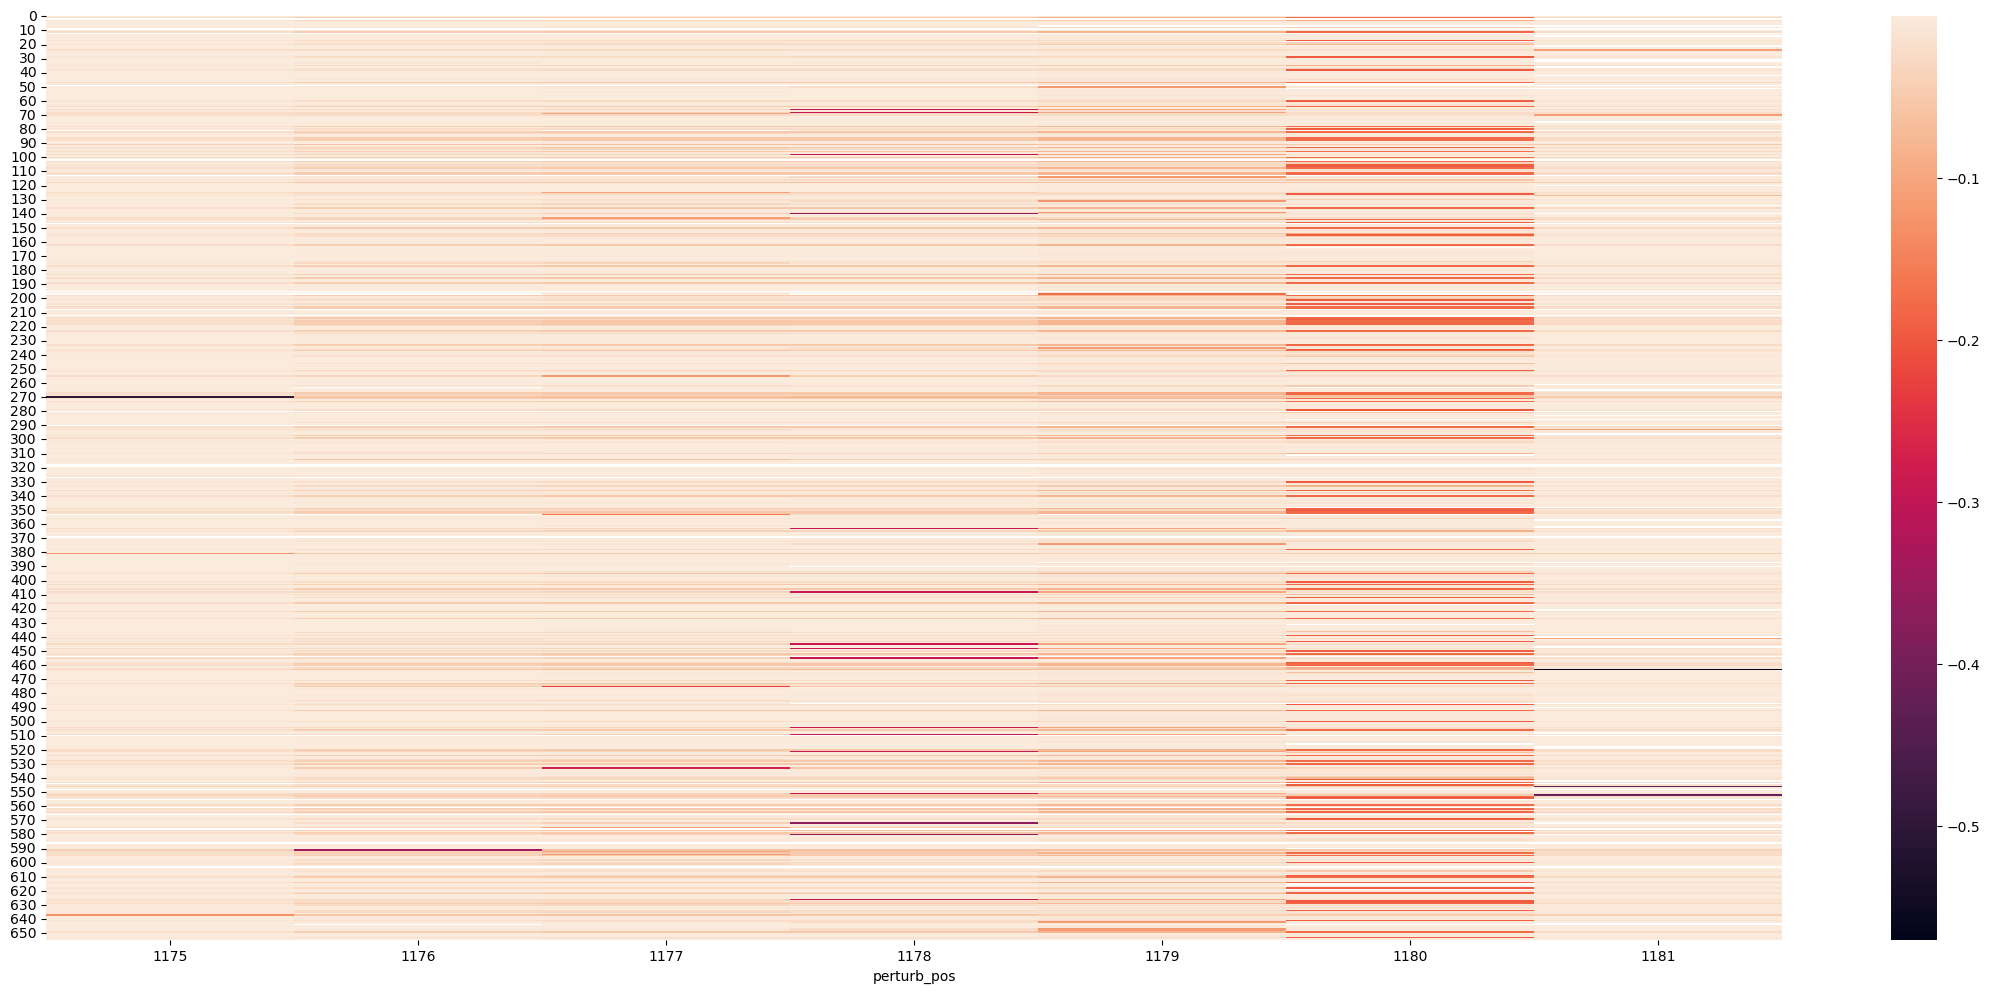

In [68]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

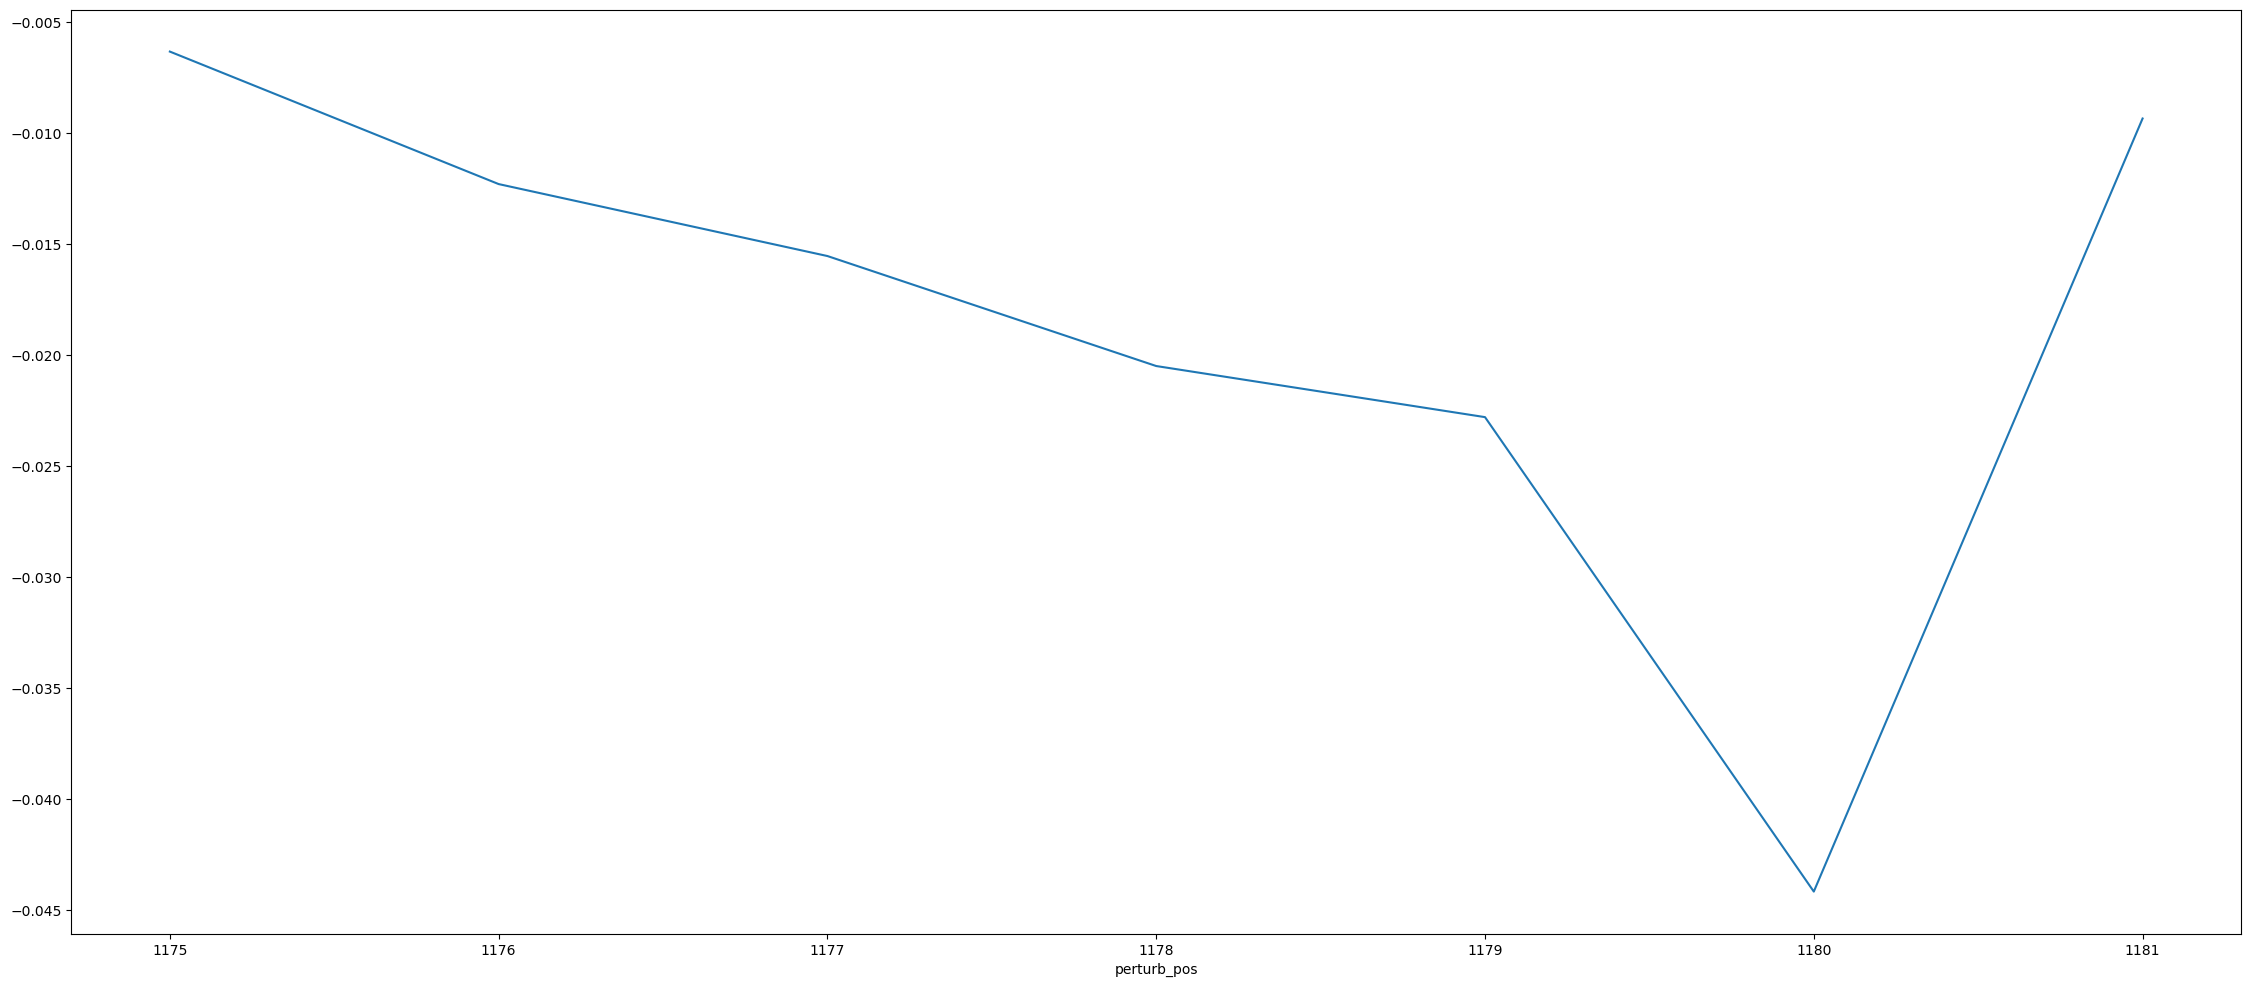

In [69]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [70]:
mean_diff_df.mean(axis=0).nsmallest(10)

perturb_pos
1180   -0.044153
1179   -0.022785
1178   -0.020484
1177   -0.015530
1176   -0.012289
1181   -0.009336
1175   -0.006321
dtype: float64